# 1. Preparing the data

In [2]:
import os
os. chdir("c:\\Users\\simon\\OneDrive\\Dokumente\\UNILU\\3 - HS24\\1 MA\\business-reports-nlp")

Set up conversion and convert training data.

In [7]:
import json
import pandas as pd

system_message = "You are a text classifier and your task is to classifiy a given text into the following categories: ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. You should directly output the predicted label only. Your answer should be either one of ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. Do not output a sentence."
#additional_knowledge = "You will learn the definition of every category from the following list: . Following the knowledge from these definitions and according to your fine-tuning you will label the new data."

#df = pd.read_excel("data/fine-tuning v1/training.xlsx")
df = pd.read_csv("data/fine-tuning v1/training.csv")
df = df.sample(frac=1).reset_index(drop=True)
path = "data/fine-tuning v1/train.jsonl"

# Function to convert DataFrame to JSONL format
def convert_to_jsonl(df, system_message="You are a text classification machine"):
    with open(path, 'w') as file:
        for index, row in df.iterrows():
            entry = {
                "messages": [
                    {"role": "system", "content": system_message}, # + additional_knowledge},
                    {"role": "user", "content": row['content']},
                    {"role": "assistant", "content": row['classification']}
                ]
            }
            json_line = json.dumps(entry)
            file.write(json_line + '\n')

# Call the function
path = "data/fine-tuning v1/train.jsonl"
convert_to_jsonl(df)

Convert validation data.

In [10]:
#df = pd.read_excel("data/fine-tuning v1/validation.xlsx")
df = pd.read_csv("data/fine-tuning v1/validation.csv")
df = df.rename({'corrected': 'classification'}, axis=1)
path = "data/fine-tuning v1/test.jsonl"
convert_to_jsonl(df)

# 2. Uploading the data

Note that this was achieved directly in the OpenAI platform.

In [ ]:
# import openai

# response = openai.File.create(
#     file=open("data/train.jsonl", "rb")
#     purpose='fine-tune'
# )

# print(response)

# 3. Training the model

Note that this was achieved directly in the OpenAI platform.

In [ ]:
# import os
# import openai
# openai.api_key = os.getenv("OPENAI_API_KEY")
# file_id = ""
# response = openai.FineTuningJob.create(traning_file=file_id, model="gpt-3.5 turbe")

# print(response)

# 4. Using the model

In [2]:
import pandas as pd

#df = pd.read_excel("data/test.xlsx", engine='openpyxl')
df = pd.read_csv("data/fine-tuning v1/validation.csv")

In [3]:
from openai import OpenAI
import pandas as pd

with open('OPENAI_API_KEY.txt') as f:
    openai_api = f.readlines()
openai_api = openai_api[0]
client = OpenAI(
    api_key=openai_api
)

system_message = "You are a text classifier and your task is to classifiy a given text into the following categories: ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. You should directly output the predicted label only. Your answer should be either one of ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. Do not output a sentence."

def classify_texts(df, system_message):
    classifications = []

    for text in df['content']:
        response = client.chat.completions.create(
                model='ft:gpt-3.5-turbo-1106:personal::8cEJm6ed',
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": text},
                ]
        )
        # Extract content from response and append to list
        classifications.append(response.choices[0].message.content)
    
    # Add classifications as new column to df
    df['240101_preds'] = classifications

# Initiate classification
classify_texts(df, system_message)

In [4]:
# Save the DataFrame with prompts and responses to a new CSV file
df.to_csv('data/fine-tuning v1/240101_validation_results.csv', index=False)

## Fine-tuning metrics

In [15]:
import pandas as pd

ft_metrics = pd.read_excel('data/fine-tuning v1/fine-tuning-metrics.xlsx')

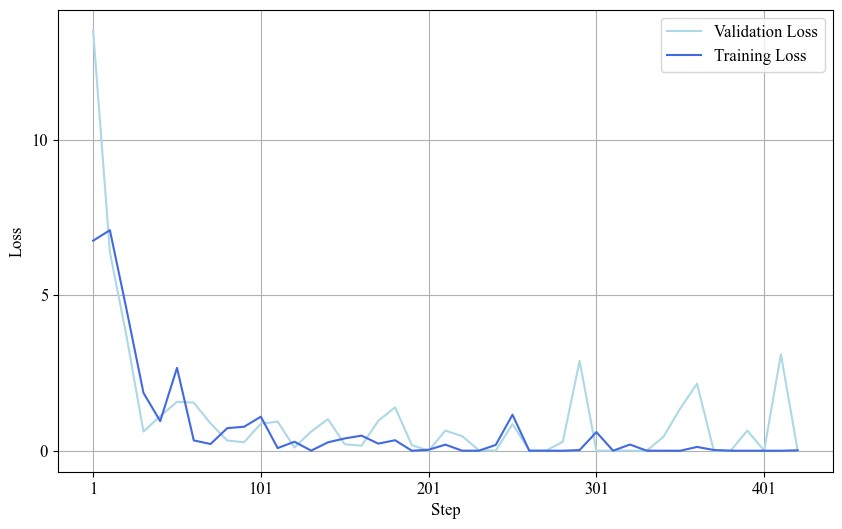

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(ft_metrics['Step'], ft_metrics['Validation loss'], label='Validation Loss', color='Lightblue')
plt.plot(ft_metrics['Step'], ft_metrics['Training loss'], label='Training Loss', color='Royalblue')

# Set x-axis ticks
plt.xticks(np.arange(1, 421, 100))
plt.yticks(np.arange(0, 15, 5))

# Labeling the plot
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.savefig('figs/automated_content_analysis/ft_metrics.png', dpi=1200, bbox_inches='tight')
plt.show()

# Evaluating the results

In [31]:
import pandas as pd

df = pd.read_csv('data/fine-tuning v1/240101_validation_results.csv')

In [32]:
df['predictions'] = df['predictions'].replace("Interactions between Payments Players", "Interactions Between Payments Players")
df['240101_preds'] = df['240101_preds'].replace("Interactions between Payments Players", "Interactions Between Payments Players")
df['240101_preds'] = df['240101_preds'].replace("Interactions between Payment Players", "Interactions Between Payments Players")
df['classification'] = df['classification'].replace("Interactions between Payments Players", "Interactions Between Payments Players")

In [33]:
# Calculate the percentage of matching entries
matches = df['classification'] == df['240101_preds']
match_percentage = matches.sum() / len(df) * 100

print(f"Percentage of matching entries: {match_percentage:.2f}%")

Percentage of matching entries: 65.20%


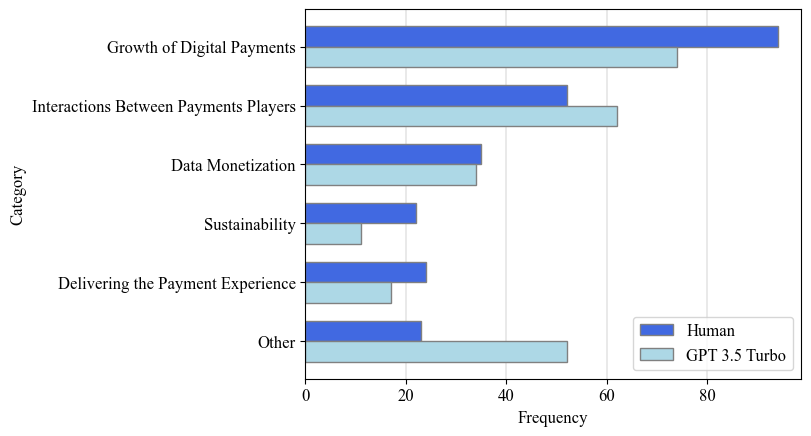

In [34]:
import matplotlib.pyplot as plt
plt.style.use("default")
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
import numpy as np

# Count the occurrences for each column
classification_counts = df['classification'].value_counts()
predictions_counts = df['240101_preds'].value_counts()

categories =  ['Growth of Digital Payments', 'Interactions Between Payments Players', 'Data Monetization', 'Sustainability', 'Delivering the Payment Experience', 'Other']
categories.reverse()
classification_counts = classification_counts.reindex(categories)
predictions_counts = predictions_counts.reindex(categories)

# plotting
# Bar width
bar_width = 0.35

# Positions of bars on the x-axis
r1 = np.arange(len(predictions_counts))
r2 = [x + bar_width for x in r1]

# Creating the bar plot
bars1 = plt.barh(r2, classification_counts, color='royalblue', height=bar_width, edgecolor='grey', label='Human')
bars2 = plt.barh(r1, predictions_counts, color='lightblue', height=bar_width, edgecolor='grey', label='GPT 3.5 Turbo')
# Add labels
plt.xlabel('Frequency')
plt.ylabel('Category')
#plt.title('Text Length for Each Measurement Type')
plt.yticks([r + bar_width/2 for r in range(len(predictions_counts))], categories)
plt.legend()
# Adding labels to each bar
#for bar in bars1:
    #plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
#for bar in bars2:
    #plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
# Change x-axis to display real numbers
plt.gca().ticklabel_format(style='plain', axis='x', useOffset=False)
# Add grid
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', axis='x', color='gray', linestyle='-', linewidth=0.25)
plt.savefig('figs/automated_content_analysis/validation-counts.png', dpi=1200, bbox_inches='tight')
# Show the plot
plt.show()

In [11]:
#df['classification'].unique()
df['240101_preds'].unique()
#df['predictions'].unique()

array(['Interactions Between Payments Players',
       'Growth of Digital Payments', 'Sustainability',
       'Data Monetization', 'Other', 'Delivering the Payment Experience'],
      dtype=object)

In [13]:
from sklearn.metrics import classification_report

report = classification_report(df['classification'], df['240101_preds'])
print(report)

                                       precision    recall  f1-score   support

                    Data Monetization       0.62      0.60      0.61        35
    Delivering the Payment Experience       0.71      0.50      0.59        24
           Growth of Digital Payments       0.84      0.66      0.74        94
Interactions Between Payments Players       0.68      0.81      0.74        52
                                Other       0.35      0.78      0.48        23
                       Sustainability       0.73      0.36      0.48        22

                             accuracy                           0.65       250
                            macro avg       0.65      0.62      0.61       250
                         weighted avg       0.71      0.65      0.66       250



In [16]:
print(classification_report(df['classification'], df['predictions']))

                                       precision    recall  f1-score   support

                    Data Monetization       0.64      1.00      0.78        35
    Delivering the Payment Experience       0.90      0.38      0.53        24
           Growth of Digital Payments       0.91      0.88      0.90        94
Interactions Between Payments Players       0.78      0.96      0.86        52
                                Other       0.88      0.30      0.45        23
                       Sustainability       0.77      0.77      0.77        22

                             accuracy                           0.80       250
                            macro avg       0.81      0.72      0.72       250
                         weighted avg       0.83      0.80      0.79       250



# Ultimate Classification

In [15]:
import pandas as pd

df = pd.read_csv("data/fine-tuning v1/classification.csv")

In [16]:
from openai import OpenAI
import pandas as pd

with open('OPENAI_API_KEY.txt') as f:
    openai_api = f.readlines()
openai_api = openai_api[0]
client = OpenAI(
    api_key=openai_api
)

system_message = "You are a text classifier and your task is to classifiy a given text into the following categories: ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. You should directly output the predicted label only. Your answer should be either one of ['Data Monetization', 'Growth of Digital Payments', 'Delivering the Payment Experience', 'Interactions between Payments Players', 'Sustainability', 'Other']. Do not output a sentence."

def classify_texts(df, system_message):
    classifications = []

    for text in df['content']:
        response = client.chat.completions.create(
                model='ft:gpt-3.5-turbo-1106:personal::8cEJm6ed',
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": text},
                ]
        )
        # Extract content from response and append to list
        classifications.append(response.choices[0].message.content)
    
    # Add classifications as new column to df
    df['240101_preds'] = classifications

# Initiate classification
classify_texts(df, system_message)


# Save the DataFrame with prompts and responses to a new CSV file
df.to_csv('data/fine-tuning v1/240101_classification_results.csv', index=False)

In [18]:
df['240101_preds'].value_counts()

240101_preds
Interactions between Payments Players    3514
Growth of Digital Payments               2600
Other                                    2440
Data Monetization                        1476
Delivering the Payment Experience         998
Sustainability                            435
Name: count, dtype: int64